# Diachronic semantic change with count vectors

In [177]:
!pip install rpy2

In [178]:
rebuild = False

In [179]:
import os
import pandas as pd
import time
from nltk.util import skipgrams
from nltk.lm import NgramCounter
import plotly.express as px

In [180]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects import StrVector, IntVector
from rpy2.rinterface_lib.embedded import RRuntimeError # handling R runtime errors
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
r_libs = '/home/krzys/R/x86_64-pc-linux-gnu-library/4.1'# R libs
base = importr('base')
print(base._libPaths())
utils.install_packages("wordspace")
wordspace = importr("wordspace", lib_loc=r_libs)

R[write to console]: Instalowanie pakietu w ‘/home/krzys/R/x86_64-pc-linux-gnu-library/4.1’
(ponieważ ‘lib’ nie jest określony)



[1] "/home/krzys/R/x86_64-pc-linux-gnu-library/4.1"
[2] "/usr/local/lib/R/site-library"                
[3] "/usr/lib/R/site-library"                      
[4] "/usr/lib/R/library"                           



R[write to console]: próbowanie adresu URL 'https://cloud.r-project.org/src/contrib/wordspace_0.2-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1839490 bytes (1.8 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/home/krzys/R/x86_64-pc-linux-gnu-library/4.1/Rcpp/include'   -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/home/krzys/R/x86_64-pc-linux-gnu-library/4.1/Rcpp/include'   -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c wordspace.cpp -o wordspace.o
g++ -std=gnu++14 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o wordspace.so RcppExports.o wordspace.o -fopenmp -L/usr/lib/R/lib -lR


installing to /home/krzys/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-wordspace/00new/wordspace/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (wordspace)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmphSxEIu/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [181]:
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [182]:
dir_out = os.path.join('.', 'out')
if not os.path.isdir(dir_out):
    os.mkdir(dir_out)

dir_out_models = os.path.join(dir_out, 'models')
if not os.path.isdir(dir_out_models):
    os.mkdir(dir_out_models)

## Terms
We are interested in semantic change patterns of a set of terms related to the socio-political life, such as:

In [183]:
# define terms we're interested in
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator",
                         "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]
print(socio_political_terms)

['civitas', 'consilium', 'consul', 'dux', 'gens', 'hostis', 'imperator', 'jus', 'labor', 'natio', 'nobilitas', 'pontifex', 'pontificium', 'populus', 'potestas', 'regnum', 'senatus', 'sodes', 'urbs']


We're assigning each term a seperate colour to facilitate our analyses.

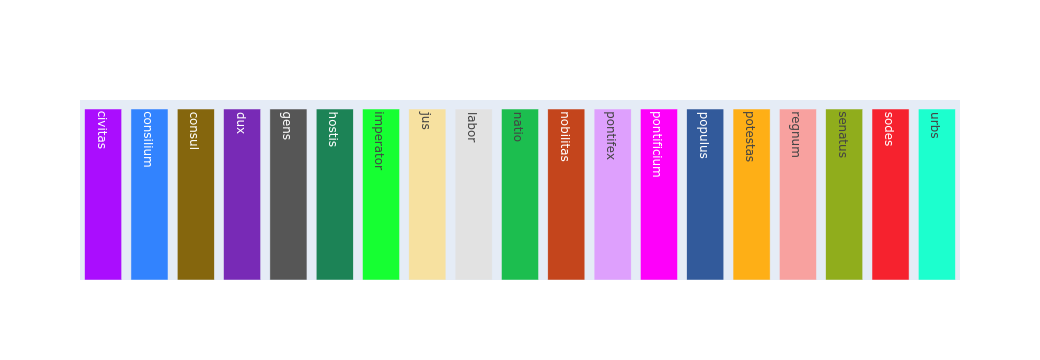

In [184]:
color_discrete_map_terms = { term : px.colors.qualitative.Alphabet[i] for i, term in enumerate(socio_political_terms)} # for each term we fix a color
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [col for col in color_discrete_map_terms.keys()],
    y = [0.5 for x in range(0, len(color_discrete_map_terms)) ],
    text = socio_political_terms,
    textangle=90,
    marker_color=[col for col in color_discrete_map_terms.values()]
))
fig.update_layout(showlegend=False, xaxis={'showgrid': False, 'visible': False}, yaxis={'showgrid': False, 'visible': False})

## The corpus

The corpus processing phase follows as close as possible BMG's workflow to keep models compatible. There are 2 exceptions:

- all lemmas are converted to lowercase and
- anomalous lemmas (mostly punctuation) are added to stopword list.

In [185]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n']

In [186]:
# corpus files
#dir_in = os.path.join("/home/krzys/Kod/streamlit/voces/data/corpora/latinise_IT_lemmas/")
dir_input =  os.path.join("/home/krzys/Kod/lvlt22/BMG/LatinISE_1/") # includes texts first omitted due to parsing issues
dir_in = os.path.join(dir_input, "preprocessed_lemmas")
dir_in_words = os.path.join(dir_input, "preprocessed_tokens")    
files = os.listdir(os.path.join(dir_in))
files = [f for f in files[:] if "IT" in f]

#### Process the metadata
We'll be storing corpus metadata in a data frame.

In [187]:
# metadata (BMG)
metadata_df = pd.read_csv(os.path.join(dir_input, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df.head()
metadata_df["date"] = metadata_df["date"].astype('int') #ensure we're working with integers

In [188]:
first_date = min(metadata_df.date)

In [189]:
last_date = 900 # BMG

Define size of the time intervals:

In [190]:
size_interval = 450 # BMG

So there are

In [191]:
n_intervals = round((last_date-first_date)/size_interval) # BMG
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [192]:
intervals = [None]*(n_intervals+1) # BMG
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)
periods_labels = [ str(p1) + '-' + str(p2) for p1, p2 in zip(intervals, intervals[1:]) ]
print(periods_labels)

[-450, 0, 450, 900]
['-450-0', '0-450', '450-900']


Add a column to the metadata_df for the time interval:

In [193]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64


,id,title,creator,date,type,file,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,0
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,0
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0


In [194]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

### Read in corpus files

In [195]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n', '']

In [196]:
# define corpus subset
corpus_subset = metadata_df[metadata_df['date'] <= last_date].copy().reset_index(drop=True)
filenames_subset = corpus_subset['file'] # filenames were defined above to get IT files only

In [197]:
from nltk.corpus.reader.plaintext import PlaintextCorpusReader, CategorizedPlaintextCorpusReader
from nltk.tokenize.simple import SpaceTokenizer, LineTokenizer
from nltk.text import Text, TextCollection
class NltkCorpusFromDirNew(PlaintextCorpusReader):
    "A subclass of NLTK PlaintextCorpusReader"
    
    word_tokenizer=SpaceTokenizer() # tokenize on whitespace
    sent_tokenizer=LineTokenizer() # assume sentence per line
    
    def __init__(
        self,
        root,
        fileids,
        encoding="utf8",        
        word_tokenizer=word_tokenizer,
        sent_tokenizer=sent_tokenizer,
        tolower=False, punctuation=None
    ):

        PlaintextCorpusReader.__init__(self, root=root, fileids=fileids, encoding=encoding,
                                       word_tokenizer=word_tokenizer,
                                       sent_tokenizer=sent_tokenizer)
        self.tolower = tolower
        self.punctuation = punctuation
        
    def _read_word_block(self, stream):
        words = []
        for i in range(20):  # Read 20 lines at a time.
            if self.punctuation is not None:
                words.extend( [ token.lower() if self.tolower == True else token for token 
                               in self._word_tokenizer.tokenize(stream.readline()) 
                               if token not in self.punctuation and token != '' 
                              ])
            else:
                words.extend( [ token.lower() if self.tolower == True else token for token in self._word_tokenizer.tokenize(stream.readline()) ])
        return words

In [198]:
#prepare the corpus
latinise = NltkCorpusFromDirNew(root=dir_in, fileids=filenames_subset,
                                punctuation=punctuation, tolower=True)
latinise_docs = []
for fileid in latinise.fileids():
    latinise_docs.append(Text(latinise.words(fileid)))
print("This corpus contains ", len(latinise_docs), " documents.")

This corpus contains  385  documents.


In [207]:
corpus = latinise

## The diachronic corpus
The corpus will be now splitted into slices, each covering `size_interval` years.

In [208]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
#for t in range(n_intervals+1): # remove redundant 900 interval
for t in range(n_intervals):
    files_corpus_t = list(corpus_subset.loc[corpus_subset['time_interval'] == intervals[t]]["file"])
    print("retrieving the subcorpus for interval ", intervals[t])
    sents = latinise.sents(fileids=files_corpus_t)
    sents_clean = list()
    for sent in sents:
        sents_clean.append( [ token.lower()  for token in sent if token not in punctuation and token != ''  ] )
    time2corpus[t] = sents_clean

retrieving the subcorpus for interval  -450
retrieving the subcorpus for interval  0
retrieving the subcorpus for interval  450


The `time2corpus` variable is a dictionary with time slices as keys. Each item is a list of sentences, each being a list of lemmas.

In [209]:
print(f'Dictionary keys are: { [ period for period in time2corpus.keys()] }')
print('First 3 sentences from the 3rd corpus slice are: ', time2corpus[2][0:2])

Dictionary keys are: [0, 1, 2]
First 3 sentences from the 3rd corpus slice are:  [['obsculta', 'o', 'filius', 'praeceptum', 'magister', 'et', 'inclino', 'auris', 'cor', 'tuus', 'et', 'admonitio', 'pius', 'pater', 'libet', 'excipe', 'et', 'efficaciter', 'comple', 'ut', 'ad', 'is', 'per', 'oboedientia', 'labor', 'redeo', 'ab', 'quo', 'per', 'inoboedientia', 'desidia', 'recedo'], ['ad', 'tu', 'ergo', 'nunc', 'ego', 'sermo', 'dirigo', 'quisquis', 'abrenuntio', 'proprius', 'voluntas', 'dominus', 'christus', 'verus', 'rex', 'militaturus', 'oboedientia', 'fortis', 'atque', 'praeclarus', 'arma', 'sumo']]


In [210]:
time2corpus[2][0:1]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo']]

# Building DSMs

In `rebuild` mode we'll compile DSMs using Stephanie Evert's `R` package `wordspace`. If not otherwise stated, all terms used come from [the package's documentation](https://cran.r-project.org/web/packages/wordspace/wordspace.pdf).

## The entire corpus

### Retrieving co-occurrence counts

In [217]:
ngrams = list()
window=count_vectors_conf["window"]
skip=2 # defines distance if skipgram
ngrams = [ skipgrams(sent, window, skip) for sent in corpus.sents() ]
ngram_counts = NgramCounter(ngrams)

In [218]:
# get triples (target, feature, freq) from the ngram_counts
coocs = []
for node, freqs in ngram_counts[window].items(): # dict_items([(('ars',), FreqDist({'et': 149, 'sum': 129, ...}}))])
    #print(word)
    for cooc, freq  in freqs.items():
        triple = (node[0], cooc, freq) # node term, cooc, freq
        coocs.append(triple)    
print(coocs[0:10])

[('in', 'principium', 157), ('in', 'creo', 48), ('in', 'deus', 997), ('in', 'medius', 1119), ('in', 'aqua', 339), ('in', 'et', 8261), ('in', 'locus', 2395), ('in', 'unus', 1183), ('in', 'sui', 59), ('in', 'ipse', 2108)]


In [219]:
# convert cooc counts to matrix
coocs_df = pd.DataFrame(coocs, columns=["target", "feature", "score"])
print("the source df has ", len(coocs_df), " rows")
coocs_df.head()

the source df has  4628666  rows


,target,feature,score
0,in,principium,157
1,in,creo,48
2,in,deus,997
3,in,medius,1119
4,in,aqua,339


Apply the frequency threshold to filter out rare cooccurrences.

In [220]:
coocs_df = coocs_df[coocs_df["score"] >= 5]
print("the filtered df has ", len(coocs_df), " rows")
coocs_df.head()

the filtered df has  379223  rows


,target,feature,score
0,in,principium,157
1,in,creo,48
2,in,deus,997
3,in,medius,1119
4,in,aqua,339


### Compiling DSMs

#### Configuration

Parameters were selected empirically by comparing top 10 neighbours returned under different setups. We found that:
- dimensionality reduction **deteriorates** the results significantly;
- normalization or projection method (rsvd / svd) **do not impact** the results;
- applying particular association measure to raw frequency counts yields results conformant with the known properties of the measure,
- applying frequency threshold **improves** the results.

The parameters are:
- association measure: `log-likelihood`
- min frequency: 5,
- non-reduced matrices will be used for computing similarities.

In [221]:
count_vectors_conf = dict(
    window = 2,
    score = "log-likelihood",
    transform = "log",
    min_f = 5,
    size = "100", # dimensions after reduction
    method = "euclidean",
    reduce_method = "svd",
    normalize = True
)

#### Building models

Let's first initialize the model.

In [222]:
if rebuild == True:
    # create dsm matrix
    VObj = wordspace.dsm(target=StrVector(coocs_df["target"]),
                         feature=StrVector(coocs_df["feature"]),
                         score=IntVector(coocs_df["score"]),
                         raw_freq=True) 
    print(VObj)

Let's now apply association measures to raw frequency counts.

In [223]:
print(count_vectors_conf, "\n")
if rebuild == True:    
    VObj_weighted = wordspace.dsm_score(VObj,
                                        score=count_vectors_conf["score"],
                                        transform=count_vectors_conf["transform"],
                                        normalize=count_vectors_conf["normalize"],
                                        method=count_vectors_conf["method"])
    print(VObj_weighted)

{'window': 2, 'score': 'log-likelihood', 'transform': 'log', 'min_f': 5, 'size': '100', 'method': 'euclidean', 'reduce_method': 'svd', 'normalize': True} 

Distributional Semantic Model with 4180 rows x 4480 columns
* raw co-occurrence matrix M available
  - sparse matrix with 76.9k / 18.7M nonzero entries (fill rate = 0.41%)
  - in canonical format
  - known to be non-negative
  - sample size of underlying corpus: 1377.9k tokens
* scored matrix S available
  - sparse matrix with 68.3k / 18.7M nonzero entries (fill rate = 0.36%)
  - in canonical format
  - known to be non-negative



We're also compiling the reduced version of the model regardless of whether we use it in this study or not.

In [224]:
if rebuild == True:
    VObj_weighted_reduced = wordspace.dsm_projection(VObj_weighted,
                                                     method=count_vectors_conf["reduce_method"],
                                                     n=count_vectors_conf["size"])
    print(VObj_weighted_reduced[0]) # takes around 5 mins

0.2308572297254996


In [225]:
if rebuild == True:
    # save matrices to disk
    matrices = [VObj_weighted, VObj_weighted_reduced]
    import pickle
    
    f = open(os.path.join(dir_out_models, 'dsm_matrices.model'), 'wb')
    pickle.dump(matrices,f)

if rebuild == False:
    import pickle
    f = open(os.path.join(dir_out_models, 'dsm_matrices.model'), 'rb')
    matrices = pickle.load(f)
    VObj_weighted = matrices[0]
    VObj_weighted_reduced = matrices[1]

#### Testing models

In [226]:
# get similar from unreduced space
for term in socio_political_terms:
    print (term, "\n")
    try:
        print(wordspace.nearest_neighbours(VObj_weighted, term, n=10))
    except RRuntimeError:
        print("term not found\n")

# get similar from reduced space
for term in socio_political_terms:
    print (term, "\n")
    try:
        print(wordspace.nearest_neighbours(VObj_weighted_reduced, term, n=10))
    except RRuntimeError:
        print("term not found\n")

R[write to console]: Błąd w poleceniu '(function (M, term, n = 10, M2 = NULL, byrow = TRUE, drop = TRUE, ':
  target term(s) not found in M: pontificium

R[write to console]: Dodatkowo: 
R[write to console]: Było 27 ostrzeżenie (użyj 'warnings()' aby je zobaczyć)
R[write to console]: 

R[write to console]: Błąd w poleceniu '(function (M, term, n = 10, M2 = NULL, byrow = TRUE, drop = TRUE, ':
  target term(s) not found in M: sodes



civitas 

    urbs  francus    locus  castrum      dux    venio pervenio princeps 
67.00073 70.16291 70.84033 71.75759 72.33732 72.69251 72.96731 73.33562 
  italia   gallia 
73.54130 73.70728 

consilium 

   ostendo     regina  consensus interficio   cognosco     adduco       puer 
  58.55394   60.68176   60.90669   61.29978   61.46468   61.70101   62.16872 
   dispono      cupio    populus 
  62.36554   62.40001   62.78831 

consul 

     caesar       civis    continuo    claudius     procreo    deterior 
   60.54166    61.19427    63.30843    63.35773    63.79512    64.90941 
  populus#2      impero proficiscor       pugno 
   65.36455    65.54737    65.57447    65.60220 

dux 

      francus      pippinus     exercitus langobardorum      gothorum 
     63.25092      63.71819      63.94813      64.56727      64.69378 
     commoveo          seni        iterum        dirigo          gens 
     65.69126      65.79741      65.96795      66.80967      67.12304 

gens 

        dux orie

R[write to console]: Błąd w poleceniu '(function (M, term, n = 10, M2 = NULL, byrow = TRUE, drop = TRUE, ':
  target term(s) not found in M: pontificium

R[write to console]: Błąd w poleceniu '(function (M, term, n = 10, M2 = NULL, byrow = TRUE, drop = TRUE, ':
  target term(s) not found in M: sodes



   caput   pietas   sensus defensio   hostis   socius      ars    vinco 
43.06366 43.30626 45.90136 47.32723 47.75957 48.27229 48.55463 48.57672 
     lis    salus 
49.21210 50.55080 

natio 

    facies     pontus    vigilia    reperio   strenuus  comitibus      maria 
  26.23378   40.48589   41.91973   43.29327   44.10454   44.78782   45.31298 
similitudo    aspicio aedificium 
  45.33821   45.58027   45.90644 

nobilitas 

 praeclarus     monitum   emendatio       asper conversatio   persevero 
          0           0           0           0           0           0 
       gula     oboedio   servitium       mitis 
          0           0           0           0 

pontifex 

  lectio     exeo    villa  fluvius     mons     papa    tollo sacerdos 
43.73190 45.95323 45.96385 46.30315 46.55659 46.64106 46.68661 47.33046 
 sanguis  deficio 
47.58648 48.35171 

pontificium 

term not found

populus 

   coepio     terra    loquor consilium      meus       sic       pax       dux 
 44.0066

## The diachronic corpus

#### Configuration

In [227]:
count_vectors_conf = count_vectors_conf
print(count_vectors_conf)

{'window': 2, 'score': 'log-likelihood', 'transform': 'log', 'min_f': 5, 'size': '100', 'method': 'euclidean', 'reduce_method': 'svd', 'normalize': True}


#### Building models

In [228]:
models_diachronic = dict()
skip=2 # max offset between terms
window=2 # n-gram
threshold = True # do we apply frequency threshold?
if rebuild == True:
    start = time.time()
    for t in range(len(time2corpus)):
        if len(time2corpus[t])>0:
            print("Building model for t = ", t, "\n")

            print("Retrieving coocurrence counts for t = ", t, "\n")
            #prepare coocs
            ngrams = list()
            ngrams = [ skipgrams(sent, window, skip) for sent in time2corpus[t] ]
            ngram_counts = NgramCounter(ngrams)

            print("Retrieving (target, feature, freq) from the ngram_counts for t = ", t, "\n")
            # get triples (target, feature, freq) from the ngram_counts
            coocs = []
            for node, freqs in ngram_counts[window].items(): # dict_items([(('ars',), FreqDist({'et': 149, 'sum': 129, ...}}))])
                for cooc, freq  in freqs.items():
                    triple = (node[0], cooc, freq) # node term, cooc, freq
                    coocs.append(triple)

            coocs_df = pd.DataFrame(coocs, columns=["target", "feature", "score"])
            print("the source df has ", len(coocs_df), " rows")
            coocs_df.head()
            
            if threshold:                
                print("Apply frequency threshold")
                coocs_df = coocs_df[coocs_df["score"] >= count_vectors_conf["min_f"]]
                print("the filtered df has ", len(coocs_df), " rows")
                coocs_df.head()
            
            print("Building DSM matrices for t = ", t, "\n")

            # create dms matrix
            VObj = wordspace.dsm(target=StrVector(coocs_df["target"]),
                                 feature=StrVector(coocs_df["feature"]),
                                 score=IntVector(coocs_df["score"]),
                                 raw_freq=True) 
            VObj_weighted = wordspace.dsm_score(VObj, score=count_vectors_conf["score"],
                                                transform=count_vectors_conf["transform"],
                                                normalize=count_vectors_conf["normalize"],
                                                method=count_vectors_conf["method"])
            VObj_weighted_reduced = wordspace.dsm_projection(VObj_weighted, method=count_vectors_conf["reduce_method"], n=count_vectors_conf["size"])

            print("Saving models for t = ", t, "\n")
            models_diachronic[t] = (VObj_weighted, VObj_weighted_reduced)

    end = time.time()
    print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

Building model for t =  0 

Retrieving coocurrence counts for t =  0 

Retrieving (target, feature, freq) from the ngram_counts for t =  0 

the source df has  1401120  rows
Apply frequency threshold
the filtered df has  98362  rows
Building DSM matrices for t =  0 

Saving models for t =  0 

Building model for t =  1 

Retrieving coocurrence counts for t =  1 

Retrieving (target, feature, freq) from the ngram_counts for t =  1 

the source df has  3061758  rows
Apply frequency threshold
the filtered df has  192396  rows
Building DSM matrices for t =  1 

Saving models for t =  1 

Building model for t =  2 

Retrieving coocurrence counts for t =  2 

Retrieving (target, feature, freq) from the ngram_counts for t =  2 

the source df has  1302438  rows
Apply frequency threshold
the filtered df has  76911  rows
Building DSM matrices for t =  2 

Saving models for t =  2 

It has taken 36 seconds, or  1 minutes


In [229]:
if rebuild == True:
    # save diachronic models to disk
    import pickle
    
    with open(os.path.join(dir_out_models, 'dsm_matrices_time.model'), 'wb') as f:
        pickle.dump(models_diachronic,f)

In [230]:
if rebuild == False:
    #load models from disk
    import pickle
    
    with open(os.path.join(dir_out_models, 'dsm_matrices_time.model'), 'wb') as f:
        models_diachronic = pickle.load(f)

#### Testing models

In [231]:
# get similarity counts
for t, model in models_diachronic.items():
    if model is not None:
        print("Similarities for t =", t)
        print("Unreduced matrix for t =", t)    
        [ print(term, "\n", wordspace.nearest_neighbours(model[0], term, n=10) 
                if term in list(models_diachronic[t][0].rx2('rows').rx2("term")) else None)
         for term in socio_political_terms ]
        print("Reduced matrix for t =", t)
        [ print(term, "\n", wordspace.nearest_neighbours(model[1], term, n=10)  
                if term in list(models_diachronic[t][0].rx2('rows').rx2("term")) else None) 
         for term in socio_political_terms ]

Similarities for t = 0
Unreduced matrix for t = 0
civitas 
    munus  familia   regnum libertas  dominus   patria    nomen    civis 
70.50513 72.03306 72.12180 72.33443 72.65049 72.69315 73.15232 73.24781 
iudicium  maiores 
73.28089 73.29604 

consilium 
    summa    salus    ullus amicus#2    honor  fortuna      dux  maximus 
71.72272 73.27158 73.99808 74.03026 74.03581 74.13540 74.16459 74.65661 
     vis     arma 
74.68986 74.79322 

consul 
   praetor     annus      creo provincia  dictator      roma exercitus   legatus 
 58.55990  64.38761  65.12714  65.66345  66.74873  67.34293  68.74557  68.86243 
    mitto      inde 
 69.23820  69.65703 

dux 
   hannibal    seditio     poenus  imperator adversus#2     victor   iuventus 
  67.49320   68.10623   68.39938   68.42274   69.20574   70.24296   70.36428 
conspectus       duco      pugno 
  70.40908   70.56678   71.57088 

gens 
   perseus  iuventus   aetolus antiochus  princeps     vinco imperator finitimus 
 67.49663  68.74225  70.1

## Aligning vector spaces

In [232]:
reference_interval = "last"

In [233]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [234]:
find_reference_intervals("first", intervals)

0

In [235]:
find_reference_intervals("last", intervals)

2

We're extracting vectors from the R objects created with wordspace and saving them as dfs indexed with lemmas (the column names are svd_1..svd_dimensions).

In [236]:
if rebuild == True:
    import pandas as pd
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.conversion import localconverter

    models_dfs = {}
    for period in models_diachronic.keys():
        if models_diachronic[period] is None:
            print(period, " is None")
            continue
        else:
            print(period)
            models_dfs.setdefault(period, pd.DataFrame())
            with localconverter(ro.default_converter + pandas2ri.converter):
                model_arr = ro.conversion.rpy2py(models_diachronic[period][1])        
            model_df = pd.DataFrame(model_arr)
            model_df.index = models_diachronic[period][1].names[0]
            model_df.columns = models_diachronic[period][1].names[1]
            models_dfs[period] = model_df
        
    import pickle
    with open(os.path.join(dir_out_models, 'dsm_matrices_time_dfs.pickle'), 'wb') as f:
        pickle.dump(models_dfs,f)

if rebuild == False:
    import pickle
    with open(os.path.join(dir_out_models, 'dsm_matrices_time_dfs.pickle'), 'rb') as f:
        models_dfs = pickle.load(f)

0
1
2


Let's inspect the data.

In [237]:
for i, df in enumerate(models_dfs.values()):
    print('interval: ', i, ' shape: ', df.shape)
models_dfs[0].head()

interval:  0  shape:  (3992, 100)
interval:  1  shape:  (8033, 100)
interval:  2  shape:  (4180, 100)


,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd91,svd92,svd93,svd94,svd95,svd96,svd97,svd98,svd99,svd100
ars,0.207299,-0.083521,0.115388,-0.202472,0.129205,0.031857,0.250332,-0.101843,-0.081125,0.119524,...,0.054417,0.067668,0.034005,0.042646,-0.011756,0.065923,-0.088131,-0.026604,-0.046521,0.036904
in,0.017563,-0.011122,0.033651,-0.018961,0.068194,-0.035904,0.051080,-0.049668,0.015349,0.016720,...,0.043149,0.021971,-0.008232,0.014051,0.048338,-0.045925,-0.003805,-0.022888,0.013817,-0.042957
hic,0.024239,-0.014456,0.051619,-0.050015,0.104873,0.003021,0.107533,-0.072786,-0.010544,0.018311,...,0.040546,0.029860,-0.045327,-0.022829,0.040347,0.029633,0.046836,-0.011685,-0.039916,-0.013035
populus,0.042564,-0.026972,0.079536,-0.055661,0.142936,-0.066201,0.096751,-0.084540,0.057472,0.025203,...,0.017347,0.013257,-0.048038,0.026213,0.014933,0.023472,-0.016777,0.053093,-0.037722,0.074010
non,0.022476,-0.012385,0.052227,-0.053371,0.109791,0.032716,0.121977,-0.069377,-0.095859,0.027133,...,0.070697,-0.012694,0.009129,-0.024902,0.020070,-0.001740,0.100333,-0.023353,-0.007197,0.008631


In [238]:
def intersection_align_wordspace(m1, m2, words=None): # modified version of the gensim-based code
    """
    Intersect two wordspace count models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.index)
    vocab_m2 = set(m2.index)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    #common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True) # KN: no sorting needed
    # print(len(common_vocab))

    # Then for each model...
    m1 = m1.loc[common_vocab]
    m2 = m2.loc[common_vocab]
    
    return (common_vocab, m1, m2)

As we don't have time now to modify `wordspace` `R` objects we'll be working with numpy arrays and convert them to lemma-indexed pandas dfs. For testing purposes, let's intersect first and reference matrix.

In [239]:
common, m1, m2 = intersection_align_wordspace(models_dfs[0], models_dfs[find_reference_intervals(reference_interval, intervals)])
print(m1.shape, m2.shape)
m1.shape == m2.shape

(2232, 100) (2232, 100)


True

In [240]:
import numpy as np
def smart_procrustes_align_wordspace(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    if words is not None:
        in_base_embed, in_other_embed = base_embed.loc[words], other_embed.loc[words]
    else:
        common_vocab, in_base_embed, in_other_embed = intersection_align_wordspace(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments n the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
    # we don't need this step as we're working on matrices and not gensim objects
    #in_base_embed.wv.fill_norms(force=True)
    #in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    #base_vecs = in_base_embed.wv.get_normed_vectors()
    #other_vecs = in_other_embed.wv.get_normed_vectors()
    base_vecs = in_base_embed # just a copy
    other_vecs = in_other_embed
    #print(base_vecs.shape)
    #print(other_vecs.shape)


    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed = (other_vecs).dot(ortho)    
    
    return (other_embed, base_vecs) # we return base as well for the last


Alternatively, we may first compute common vocabulary and subset dfs.

In [241]:
common_vocab = list(set.intersection(*[set(df.index) for df in models_dfs.values()]))
print(len(common_vocab))
test = smart_procrustes_align_wordspace(models_dfs[2], models_dfs[0], words=common_vocab)
test[0].head()
test[1].head()

2196


,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd91,svd92,svd93,svd94,svd95,svd96,svd97,svd98,svd99,svd100
fas,0.587512,-0.761444,-0.269865,0.030852,-0.006545,0.026096,-0.002683,0.003050,0.007811,0.002377,...,-0.000796,-0.000411,0.000183,-0.000791,-0.000766,0.000206,-0.000622,-0.000388,-0.000289,0.001170
celebro,0.369217,-0.146784,0.297593,-0.012516,0.126633,-0.177480,0.083089,-0.167609,-0.075467,-0.035481,...,-0.006842,-0.055085,0.042315,0.001178,0.066788,0.022139,0.020776,-0.003696,0.001128,-0.011786
infinitus,0.655861,-0.170312,-0.038406,0.208305,0.030589,0.000906,-0.005348,-0.037010,-0.014458,-0.007167,...,0.069098,-0.004659,0.020254,0.001153,0.020055,0.024863,-0.004073,0.003886,-0.010237,-0.008397
manus,0.171925,0.066184,0.180336,-0.152733,0.107817,0.048625,-0.048782,-0.132336,0.169523,-0.095593,...,0.050637,-0.025671,0.028255,0.032883,0.002429,-0.043033,-0.009472,-0.043508,0.015209,-0.015512
quodsi,0.143622,-0.023775,0.379624,-0.380562,0.384963,0.474834,-0.312946,0.453448,-0.043486,-0.009643,...,-0.001265,0.000670,0.001338,0.000437,-0.003384,0.002201,-0.000969,0.001306,0.001630,0.003236


In [242]:
models_dfs_aligned = []

if reference_interval == 'last':
    ri_pos = find_reference_intervals('last', intervals)
    for i in range(0,ri_pos):
        if i + 1 < ri_pos:
            print('interval: ', i, ' comparing with: ', ri_pos)
            models_dfs_aligned.append(
                smart_procrustes_align_wordspace(models_dfs[ri_pos], models_dfs[i], words=common_vocab)[0]
            )
        else:
            # if we're processing the n-1 model we're returning both the aligned and the base model
            print('interval: ', i, ' comparing with: ', ri_pos, ' and returning the last')
            models_dfs_aligned.extend(
                smart_procrustes_align_wordspace(models_dfs[ri_pos], 
                                                 models_dfs[i], words=common_vocab) 
                
            )
    

interval:  0  comparing with:  2
interval:  1  comparing with:  2  and returning the last


Let's check the shape of the aligned matrices.

In [243]:
for i, df in enumerate(models_dfs_aligned):
    print('interval: ', i, ' shape: ', df.shape)

interval:  0  shape:  (2196, 100)
interval:  1  shape:  (2196, 100)
interval:  2  shape:  (2196, 100)


In [244]:
models_dfs[2].head()

,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,...,svd91,svd92,svd93,svd94,svd95,svd96,svd97,svd98,svd99,svd100
o,0.230857,0.097936,0.202910,-0.038122,-0.001740,-0.194123,0.100436,-0.031504,0.182504,-0.171887,...,0.083569,-0.056058,0.030802,0.014491,-0.005366,0.039792,0.028357,0.039307,0.103364,0.018315
filius,0.083652,0.005763,0.163928,-0.131132,0.010727,0.056592,-0.035181,-0.140187,0.093486,-0.233881,...,-0.031192,0.005590,0.034627,0.024009,0.054182,-0.090602,-0.104267,-0.082758,0.038880,-0.115216
praeceptum,0.481170,-0.106784,0.309873,-0.136982,-0.021319,-0.113357,0.054836,-0.093770,-0.025096,-0.208317,...,-0.059979,-0.033703,0.005699,-0.035232,0.025880,-0.007069,0.069884,0.034099,-0.140125,0.082084
magister,0.250999,0.170308,0.062591,-0.080876,-0.111029,0.012687,-0.008035,-0.103539,0.048841,-0.118968,...,-0.001276,-0.002279,0.008422,0.010560,-0.014872,-0.037560,-0.024611,0.002328,0.033437,-0.010306
et,0.009653,0.003551,0.016339,-0.015684,0.014914,0.029459,0.076885,-0.034140,0.022170,-0.008193,...,0.039623,-0.034218,0.123279,-0.011949,0.106099,-0.000747,0.028472,-0.032487,0.014022,-0.036730


In [245]:
test = smart_procrustes_align_wordspace(models_dfs[2], models_dfs[0])[1]
test.shape

(2232, 100)

# Semantic change with cosine similarity

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [246]:
from scipy import spatial
def cosine_similarity_wordspace(word, t, reference_step, models, intervals):
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] is None:
        print("Model of reference interval is empty!")
    else:
        if models[t] is not None:
            sc = 1-spatial.distance.cosine(models[t].loc[word], models[reference_interval_index].loc[word])
    return sc

In [247]:
cosine_similarity_wordspace("sum", 2, "last", models_dfs_aligned, intervals)

1

In [248]:
models_dfs_aligned[0].loc["sum"]

0     0.021785
1    -0.009414
2     0.052651
3    -0.030146
4     0.017527
        ...   
95   -0.017719
96    0.043259
97   -0.055803
98    0.036708
99   -0.007534
Name: sum, Length: 100, dtype: float64

In [249]:
cosine_similarity_wordspace("sum", 2, "first", models_dfs_aligned, intervals)

0.9022408621477278

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time intervals, and stores this in the dataframe cosine_similarity_df:

In [250]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    #print(reference_interval_index)
    if models[reference_interval_index] is not None and models[time_interval_index] is not None:
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].loc[w],
            models[time_interval_index].loc[w],
            cosine_similarity_wordspace(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].index), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [251]:
cosine_similarity_dataframe("last", 0, models_dfs_aligned, intervals)

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)"
0,fas,svd1 0.587512 svd2 -0.761444 svd3 ...,0 0.591222 1 -0.531453 2 -0.216802 3...,0.809566
1,celebro,svd1 0.369217 svd2 -0.146784 svd3 ...,0 0.665539 1 -0.159958 2 -0.100069 3...,0.460107
2,infinitus,svd1 0.655861 svd2 -0.170312 svd3 ...,0 0.554715 1 -0.073613 2 -0.015570 3...,0.566570
3,manus,svd1 0.171925 svd2 0.066184 svd3 ...,0 0.281077 1 -0.057224 2 0.154077 3...,0.508308
4,quodsi,svd1 0.143622 svd2 -0.023775 svd3 ...,0 0.467510 1 -0.185587 2 0.417176 3...,0.452829
...,...,...,...,...
2191,ibique,svd1 0.393427 svd2 0.000298 svd3 ...,0 0.593322 1 0.645161 2 -0.199922 3...,0.229604
2192,quo,svd1 0.128386 svd2 -0.126067 svd3 ...,0 0.080339 1 -0.077191 2 0.098990 3...,0.731235
2193,recedo,svd1 0.399942 svd2 0.168178 svd3 ...,0 0.544881 1 0.378996 2 0.252725 3...,0.303115
2194,adimo,svd1 0.476259 svd2 -0.358946 svd3 ...,0 0.608762 1 0.028112 2 0.340360 3...,0.483526


In [252]:
cosine_similarity_dataframe("last", 1, models_dfs_aligned, intervals)

,Word,Frequency_t_reference-last,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)"
0,fas,svd1 0.587512 svd2 -0.761444 svd3 ...,0 0.438555 1 -0.462208 2 -0.018882 3...,0.688724
1,celebro,svd1 0.369217 svd2 -0.146784 svd3 ...,0 0.573399 1 -0.127749 2 0.221591 3...,0.540590
2,infinitus,svd1 0.655861 svd2 -0.170312 svd3 ...,0 0.534913 1 -0.215024 2 -0.032159 3...,0.454348
3,manus,svd1 0.171925 svd2 0.066184 svd3 ...,0 0.139222 1 0.072236 2 0.132401 3...,0.703561
4,quodsi,svd1 0.143622 svd2 -0.023775 svd3 ...,0 0.426699 1 -0.193322 2 0.288445 3...,0.250885
...,...,...,...,...
2191,ibique,svd1 0.393427 svd2 0.000298 svd3 ...,0 0.631843 1 0.483539 2 -0.455072 3...,0.216932
2192,quo,svd1 0.128386 svd2 -0.126067 svd3 ...,0 0.085581 1 -0.076496 2 0.111761 3...,0.792654
2193,recedo,svd1 0.399942 svd2 0.168178 svd3 ...,0 0.328394 1 0.084857 2 0.306251 3...,0.695569
2194,adimo,svd1 0.476259 svd2 -0.358946 svd3 ...,0 0.493551 1 -0.075840 2 0.152703 3...,0.419034


Visualise the distribution of the semantic similarity scores with a histogram:

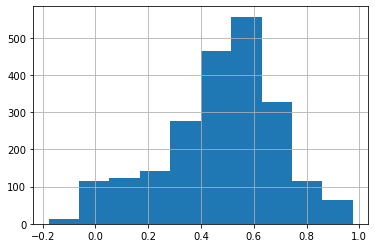

In [253]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models_dfs_aligned, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [254]:
intervals

[-450, 0, 450, 900]

In [255]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()

df = cosine_similarity_dataframe(reference_step, reference_interval_index, models_dfs_aligned, intervals)
time_series_df[df.columns[0]] = df.iloc[:,0]
time_series_df[df.columns[1]] = df.iloc[:,1]

In [256]:
models_dfs_aligned[0].loc["civitas"]

0     0.223006
1    -0.071298
2     0.215641
3    -0.093301
4    -0.030997
        ...   
95    0.007960
96   -0.022510
97   -0.004592
98    0.066673
99   -0.010150
Name: civitas, Length: 100, dtype: float64

In [257]:
time_series_df.keys()

Index(['Word', 'Frequency_t_reference-last'], dtype='object')

In [258]:
for i in range(len(models_dfs_aligned)):
    #print(reference_interval_index)
    print("Interval", str(intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models_dfs_aligned, intervals)
    if i != reference_interval_index:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models_dfs_aligned[reference_interval_index].index]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        #KN: resolve time_series_df[col_n] = [models_dfs_aligned[i].wv.similar_by_word(w, 10) for w in models_dfs_aligned[i].index]
        #print(time_series_df)
    else:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models_dfs_aligned[reference_interval_index].index]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        #KN: resolve time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    
time_series_df

Interval -450 with 450
Interval 0 with 450
Interval 450 with 450


,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,fas,svd1 0.587512 svd2 -0.761444 svd3 ...,0 0.591222 1 -0.531453 2 -0.216802 3...,0.809566,0,0 0.438555 1 -0.462208 2 -0.018882 3...,0.688724,1,svd1 0.587512 svd2 -0.761444 svd3 ...,1,2
1,celebro,svd1 0.369217 svd2 -0.146784 svd3 ...,0 0.665539 1 -0.159958 2 -0.100069 3...,0.460107,0,0 0.573399 1 -0.127749 2 0.221591 3...,0.540590,1,svd1 0.369217 svd2 -0.146784 svd3 ...,1,2
2,infinitus,svd1 0.655861 svd2 -0.170312 svd3 ...,0 0.554715 1 -0.073613 2 -0.015570 3...,0.566570,0,0 0.534913 1 -0.215024 2 -0.032159 3...,0.454348,1,svd1 0.655861 svd2 -0.170312 svd3 ...,1,2
3,manus,svd1 0.171925 svd2 0.066184 svd3 ...,0 0.281077 1 -0.057224 2 0.154077 3...,0.508308,0,0 0.139222 1 0.072236 2 0.132401 3...,0.703561,1,svd1 0.171925 svd2 0.066184 svd3 ...,1,2
4,quodsi,svd1 0.143622 svd2 -0.023775 svd3 ...,0 0.467510 1 -0.185587 2 0.417176 3...,0.452829,0,0 0.426699 1 -0.193322 2 0.288445 3...,0.250885,1,svd1 0.143622 svd2 -0.023775 svd3 ...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2191,ibique,svd1 0.393427 svd2 0.000298 svd3 ...,0 0.593322 1 0.645161 2 -0.199922 3...,0.229604,0,0 0.631843 1 0.483539 2 -0.455072 3...,0.216932,1,svd1 0.393427 svd2 0.000298 svd3 ...,1,2
2192,quo,svd1 0.128386 svd2 -0.126067 svd3 ...,0 0.080339 1 -0.077191 2 0.098990 3...,0.731235,0,0 0.085581 1 -0.076496 2 0.111761 3...,0.792654,1,svd1 0.128386 svd2 -0.126067 svd3 ...,1,2
2193,recedo,svd1 0.399942 svd2 0.168178 svd3 ...,0 0.544881 1 0.378996 2 0.252725 3...,0.303115,0,0 0.328394 1 0.084857 2 0.306251 3...,0.695569,1,svd1 0.399942 svd2 0.168178 svd3 ...,1,2
2194,adimo,svd1 0.476259 svd2 -0.358946 svd3 ...,0 0.608762 1 0.028112 2 0.340360 3...,0.483526,0,0 0.493551 1 -0.075840 2 0.152703 3...,0.419034,1,svd1 0.476259 svd2 -0.358946 svd3 ...,1,2


Print to a file:

In [259]:
time_series_df.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_allwords.csv'), index=None)

In [260]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'Frequency_t1', 'Cosine_similarity(w_t_reference-last,w_t1)',
       'interval-1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2'],
      dtype='object')

In [261]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

,interval-0,"Cosine_similarity(w_t_reference-last,w_t0)"
0,0,0.809566
1,0,0.460107
2,0,0.566570
3,0,0.508308
4,0,0.452829
...,...,...
2191,0,0.229604
2192,0,0.731235
2193,0,0.303115
2194,0,0.483526


In [262]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

<bound method NDFrame.describe of       interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0              0                                    0.809566
1              0                                    0.460107
2              0                                    0.566570
3              0                                    0.508308
4              0                                    0.452829
...          ...                                         ...
2191           0                                    0.229604
2192           0                                    0.731235
2193           0                                    0.303115
2194           0                                    0.483526
2195           0                                    0.656278

[2196 rows x 2 columns]>

In [263]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

,interval-1,"Cosine_similarity(w_t_reference-last,w_t1)"
0,1,0.688724
1,1,0.540590
2,1,0.454348
3,1,0.703561
4,1,0.250885
...,...,...
2191,1,0.216932
2192,1,0.792654
2193,1,0.695569
2194,1,0.419034


In [264]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
               ]].iloc[0]

Cosine_similarity(w_t_reference-last,w_t0)    0.809566
Cosine_similarity(w_t_reference-last,w_t1)    0.688724
Name: 0, dtype: float64

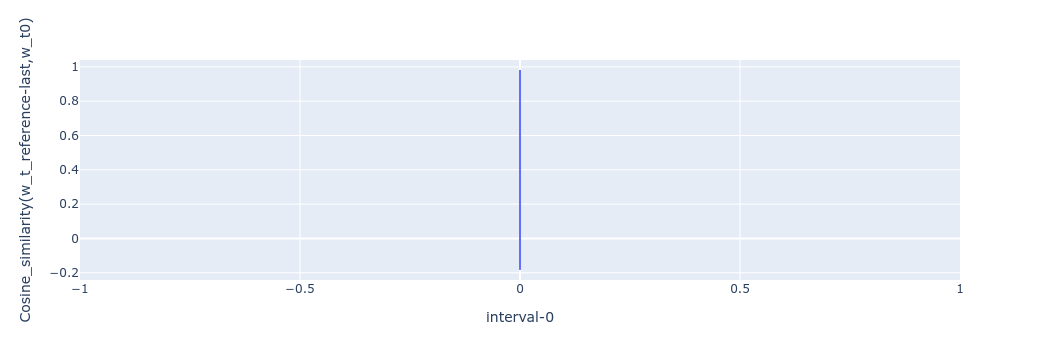

In [265]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [266]:
time_series_df

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,fas,svd1 0.587512 svd2 -0.761444 svd3 ...,0 0.591222 1 -0.531453 2 -0.216802 3...,0.809566,0,0 0.438555 1 -0.462208 2 -0.018882 3...,0.688724,1,svd1 0.587512 svd2 -0.761444 svd3 ...,1,2
1,celebro,svd1 0.369217 svd2 -0.146784 svd3 ...,0 0.665539 1 -0.159958 2 -0.100069 3...,0.460107,0,0 0.573399 1 -0.127749 2 0.221591 3...,0.540590,1,svd1 0.369217 svd2 -0.146784 svd3 ...,1,2
2,infinitus,svd1 0.655861 svd2 -0.170312 svd3 ...,0 0.554715 1 -0.073613 2 -0.015570 3...,0.566570,0,0 0.534913 1 -0.215024 2 -0.032159 3...,0.454348,1,svd1 0.655861 svd2 -0.170312 svd3 ...,1,2
3,manus,svd1 0.171925 svd2 0.066184 svd3 ...,0 0.281077 1 -0.057224 2 0.154077 3...,0.508308,0,0 0.139222 1 0.072236 2 0.132401 3...,0.703561,1,svd1 0.171925 svd2 0.066184 svd3 ...,1,2
4,quodsi,svd1 0.143622 svd2 -0.023775 svd3 ...,0 0.467510 1 -0.185587 2 0.417176 3...,0.452829,0,0 0.426699 1 -0.193322 2 0.288445 3...,0.250885,1,svd1 0.143622 svd2 -0.023775 svd3 ...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2191,ibique,svd1 0.393427 svd2 0.000298 svd3 ...,0 0.593322 1 0.645161 2 -0.199922 3...,0.229604,0,0 0.631843 1 0.483539 2 -0.455072 3...,0.216932,1,svd1 0.393427 svd2 0.000298 svd3 ...,1,2
2192,quo,svd1 0.128386 svd2 -0.126067 svd3 ...,0 0.080339 1 -0.077191 2 0.098990 3...,0.731235,0,0 0.085581 1 -0.076496 2 0.111761 3...,0.792654,1,svd1 0.128386 svd2 -0.126067 svd3 ...,1,2
2193,recedo,svd1 0.399942 svd2 0.168178 svd3 ...,0 0.544881 1 0.378996 2 0.252725 3...,0.303115,0,0 0.328394 1 0.084857 2 0.306251 3...,0.695569,1,svd1 0.399942 svd2 0.168178 svd3 ...,1,2
2194,adimo,svd1 0.476259 svd2 -0.358946 svd3 ...,0 0.608762 1 0.028112 2 0.340360 3...,0.483526,0,0 0.493551 1 -0.075840 2 0.152703 3...,0.419034,1,svd1 0.476259 svd2 -0.358946 svd3 ...,1,2


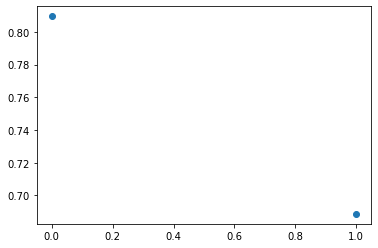

In [267]:
import matplotlib.pyplot as plt
plt.scatter([0,1], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [268]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'Frequency_t1', 'Cosine_similarity(w_t_reference-last,w_t1)',
       'interval-1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2'],
      dtype='object')

In [269]:
time_series_df.head()

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
0,fas,svd1 0.587512 svd2 -0.761444 svd3 ...,0 0.591222 1 -0.531453 2 -0.216802 3...,0.809566,0,0 0.438555 1 -0.462208 2 -0.018882 3...,0.688724,1,svd1 0.587512 svd2 -0.761444 svd3 ...,1,2
1,celebro,svd1 0.369217 svd2 -0.146784 svd3 ...,0 0.665539 1 -0.159958 2 -0.100069 3...,0.460107,0,0 0.573399 1 -0.127749 2 0.221591 3...,0.540590,1,svd1 0.369217 svd2 -0.146784 svd3 ...,1,2
2,infinitus,svd1 0.655861 svd2 -0.170312 svd3 ...,0 0.554715 1 -0.073613 2 -0.015570 3...,0.566570,0,0 0.534913 1 -0.215024 2 -0.032159 3...,0.454348,1,svd1 0.655861 svd2 -0.170312 svd3 ...,1,2
3,manus,svd1 0.171925 svd2 0.066184 svd3 ...,0 0.281077 1 -0.057224 2 0.154077 3...,0.508308,0,0 0.139222 1 0.072236 2 0.132401 3...,0.703561,1,svd1 0.171925 svd2 0.066184 svd3 ...,1,2
4,quodsi,svd1 0.143622 svd2 -0.023775 svd3 ...,0 0.467510 1 -0.185587 2 0.417176 3...,0.452829,0,0 0.426699 1 -0.193322 2 0.288445 3...,0.250885,1,svd1 0.143622 svd2 -0.023775 svd3 ...,1,2


In [270]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1.head()

,Time_interval,Cosine_sim,Word
0,0,0.809566,fas
0,1,0.688724,fas
0,0,0.460107,celebro
0,1,0.54059,celebro
0,0,0.56657,infinitus


Print to output file:

In [271]:
time_series_df1.to_csv(os.path.join(dir_out, 'semantic_change1_'+str(size_interval)+'_allwords.csv'), index=None) 

In [272]:
time_series_df_socpol = time_series_df[time_series_df['Word'].isin(socio_political_terms)]
time_series_df_socpol.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol.head()

,Word,Frequency_t_reference-last,Frequency_t0,"Cosine_similarity(w_t_reference-last,w_t0)",interval-0,Frequency_t1,"Cosine_similarity(w_t_reference-last,w_t1)",interval-1,Frequency_t2,"Cosine_similarity(w_t_reference-last,w_t2)",interval-2
92,dux,svd1 0.228212 svd2 0.097451 svd3 ...,0 0.226225 1 0.057977 2 0.133761 3...,0.655459,0,0 0.180066 1 0.058582 2 0.167666 3...,0.807631,1,svd1 0.228212 svd2 0.097451 svd3 ...,1,2
106,potestas,svd1 0.241775 svd2 -0.220196 svd3 ...,0 0.234554 1 -0.184084 2 0.174999 3...,0.706973,0,0 0.366334 1 -0.089716 2 0.246267 3...,0.668558,1,svd1 0.241775 svd2 -0.220196 svd3 ...,1,2
148,pontifex,svd1 0.462777 svd2 0.129017 svd3 ...,0 0.439059 1 -0.124470 2 0.111587 3...,0.422104,0,0 0.502493 1 0.068253 2 0.101902 3...,0.459886,1,svd1 0.462777 svd2 0.129017 svd3 ...,1,2
150,regnum,svd1 0.069925 svd2 0.009187 svd3 ...,0 0.271935 1 -0.119571 2 0.245712 3...,0.601198,0,0 0.170434 1 0.058686 2 0.163399 3...,0.703250,1,svd1 0.069925 svd2 0.009187 svd3 ...,1,2
316,consul,svd1 0.347648 svd2 -0.075148 svd3 ...,0 0.055468 1 -0.004312 2 0.116338 3...,0.506629,0,0 0.100683 1 -0.022971 2 0.172609 3...,0.690878,1,svd1 0.347648 svd2 -0.075148 svd3 ...,1,2


In [273]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1_sel = pd.DataFrame()
for index, row in time_series_df_socpol.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1_sel)

time_series_df1_sel.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1_sel

,Time_interval,Cosine_sim,Word
0,0,0.655459,dux
0,1,0.807631,dux
0,0,0.706973,potestas
0,1,0.668558,potestas
0,0,0.422104,pontifex
0,1,0.459886,pontifex
0,0,0.601198,regnum
0,1,0.70325,regnum
0,0,0.506629,consul
0,1,0.690878,consul


In [274]:
time_series_df1_socpol_sel = time_series_df1_sel[time_series_df1_sel['Word'].isin(socio_political_terms)]
time_series_df1_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol_sel

,Time_interval,Cosine_sim,Word
0,0,0.655459,dux
0,1,0.807631,dux
0,0,0.706973,potestas
0,1,0.668558,potestas
0,0,0.422104,pontifex
0,1,0.459886,pontifex
0,0,0.601198,regnum
0,1,0.70325,regnum
0,0,0.506629,consul
0,1,0.690878,consul


In [275]:
time_series_df1_socpol_sel = time_series_df1_sel[time_series_df1_sel['Word'].isin(socio_political_terms)]
time_series_df1_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol_sel

,Time_interval,Cosine_sim,Word
0,0,0.655459,dux
0,1,0.807631,dux
0,0,0.706973,potestas
0,1,0.668558,potestas
0,0,0.422104,pontifex
0,1,0.459886,pontifex
0,0,0.601198,regnum
0,1,0.70325,regnum
0,0,0.506629,consul
0,1,0.690878,consul


In [276]:
time_series_df1_socpol_sel.dtypes

Time_interval    object
Cosine_sim       object
Word             object
dtype: object

In [277]:
time_series_df1_socpol_sel.loc["Time_interval"] = pd.to_numeric(time_series_df1_socpol_sel.reset_index()["Time_interval"], downcast='integer')

In [278]:
time_series_df1_socpol_sel.head()

,Time_interval,Cosine_sim,Word
0,0,0.655459,dux
0,1,0.807631,dux
0,0,0.706973,potestas
0,1,0.668558,potestas
0,0,0.422104,pontifex


In [279]:
time_series_df1_socpol_sel.loc["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol_sel.reset_index()["Cosine_sim"], downcast='float')
time_series_df1_socpol_sel.head()

,Time_interval,Cosine_sim,Word
0,0,0.655459,dux
0,1,0.807631,dux
0,0,0.706973,potestas
0,1,0.668558,potestas
0,0,0.422104,pontifex


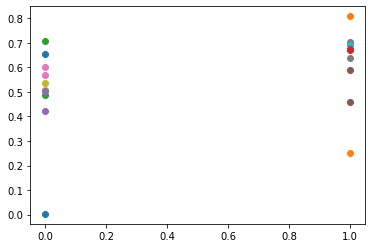

In [280]:
import matplotlib.pyplot as plt
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol_sel[['Time_interval']].iloc[i], 
            time_series_df1_socpol_sel[['Cosine_sim']].iloc[i])
plt.show()

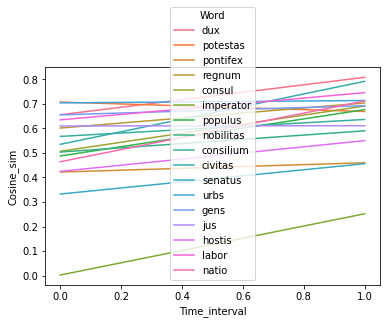

In [281]:
import seaborn as sns
time_series_df1_socpol_sel = time_series_df1_socpol_sel.reset_index()
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol_sel, hue='Word', legend="full")
plt.show()

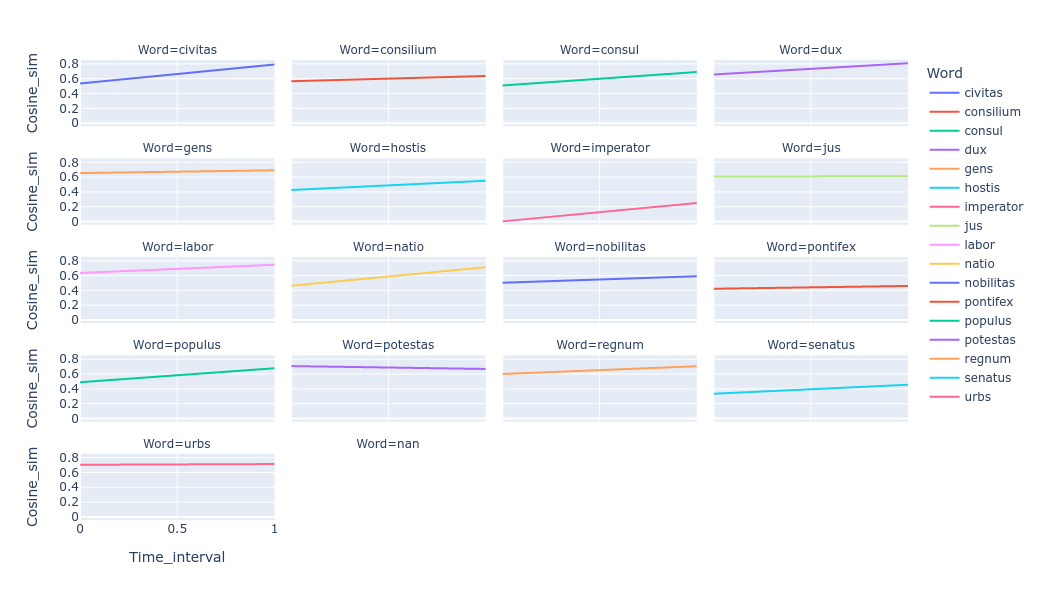

In [292]:
fig = px.line(time_series_df1_socpol_sel.sort_values("Word"), x='Time_interval', y='Cosine_sim', color = "Word",
              facet_col="Word", facet_col_wrap=4
             )
fig.update_layout(height=600, width=800)
fig.show()

# Finished here

# Experimenting

Let's test if `scipy`'s orthogonal_procrustes yields similar results to those obtained with the script.

In [ ]:
from scipy.linalg import orthogonal_procrustes # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html#rb53e47558d72-1
import numpy as np
test = orthogonal_procrustes(np.array(models_dfs[0].loc[common_vocab]).T, np.array(models_dfs[2].loc[common_vocab]).T)

In [ ]:
test[0].shape # Solution. The test[1] stores the sum of singular values
test_procrustes = pd.DataFrame(test[0])

In [ ]:
test_procrustes.head()

In [ ]:
models_dfs_aligned[0].head()

In [ ]:
# Finished HERE

For reference: the structure of wordspace objects and how to access them.

In [ ]:
#models[0][0].rx2('rows').rx2("term")

#print("Let's inspect a model: ", [ print(i) for i in models[0] ] )
#print("Let's inspect a model: ", [ len(i) for i in models[1] ] )
#print(models[1][0])
# weighted = models[0][0]
# weighted reduced = models[0][1]

#print(models[0][0]) #weighted matrix

#print(models[0][0][0]) #sparse Matrix of class "dgCMatrix"
#same as: models[0][0].rx2('M') RAW!
#print(models[0][0][1]) #term - nnzero - f
#same as: models[0][0].rx2('rows')
#print(models[0][0][2]) #term - nnzero - f
#same as: models[0][0].rx2('cols')
#print(models[0][0][3]) # $N, $locked
#same as: models[0][0].rx2('globals
#print(models[0][0][4]) # sparse Matrix of class "dgCMatrix"
#same as: models[0][0].rx2('S') WEIGHTED!

#print(models[0][1]) # reduced matrix
#print(len(models[0][1])) # reduced matrix length

#print(list(models[0][0].rx2('cols').rx2("term"))[0:10])
#list(models[0][0].rx2('cols')[0:10])
#print(list(models[0][0].rx2('rows').rx2("term"))[0:10])
#list(models[0][0].rx2('rows')[0:10])

#print(list(models[0].rx2('M')))